In [ ]:
import os
import numpy as np

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from tensorflow import keras
tf.config.set_visible_devices([], 'GPU')
print("Using CPU only.")


In [ ]:
!python --version

Python 3.9.18


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10255307905095394213
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 10038517638481251522
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2024-12-12 20:26:06.256738: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-12 20:26:06.256763: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-12 20:26:06.256770: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-12 20:26:06.257267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-12 20:26:06.257474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

載入檔案

In [ ]:
import os
import shutil
if (not os.path.isdir("已分類垃圾")):
    os.system("gdown https://drive.google.com/uc?id=1eTMU44txJ6rMJpASQl17qW9qyNPWczvt")
    shutil.unpack_archive("已分類垃圾.zip", ".")

Downloading...
From: https://drive.google.com/uc?id=1eTMU44txJ6rMJpASQl17qW9qyNPWczvt
To: /Users/daniel/Downloads/final/final/已分類垃圾.zip
100%|██████████| 273M/273M [00:26<00:00, 10.5MB/s] 


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(input_dir, output_dir, val_ratio=0.2):
    # 確保目標目錄存在
    os.makedirs(output_dir, exist_ok=True)

    # 遍歷每個類別
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # 跳過非資料夾的項目

        # 獲取該類別中的所有圖片檔案
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        # 分割為訓練集和驗證集
        train_images, val_images = train_test_split(images, test_size=val_ratio, random_state=42)

        # 創建訓練和驗證目錄
        train_dir = os.path.join(output_dir, "train", class_name)
        val_dir = os.path.join(output_dir, "val", class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # 複製圖片到對應目錄
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, img))

    print("數據集分割完成！")

# 使用範例
input_dir = "已分類垃圾"  # 原始數據集目錄
output_dir = "已分類垃圾(已分割)"  # 分割後的目錄

split_dataset(input_dir, output_dir)


數據集分割完成！


In [ ]:
base_dir = '已分類垃圾(已分割)'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 設定資料增強與重新縮放
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # 將像素值縮放到 [0, 1]
    shear_range=10,       # 隨機應用剪切變換
    zoom_range=0.2,       # 隨機縮放
    horizontal_flip=True  # 隨機水平翻轉
)

# 建立訓練集生成器
train_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),   # 調整圖片大小
    batch_size=10,          # 批次大小
    class_mode="categorical"  # 使用多類別分類（由於有八個類別）
)

# 建立驗證集生成器
val_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),   # 調整圖片大小
    batch_size=10,          # 批次大小
    class_mode="categorical"  # 使用多類別分類
)

Found 12850 images belonging to 8 classes.
Found 12850 images belonging to 8 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_set = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode="categorical")

Found 3215 images belonging to 8 classes.


Cloning into 'HappyML'...


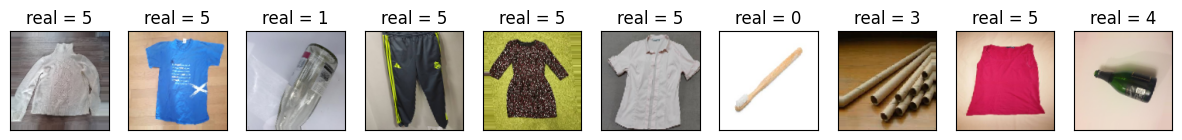

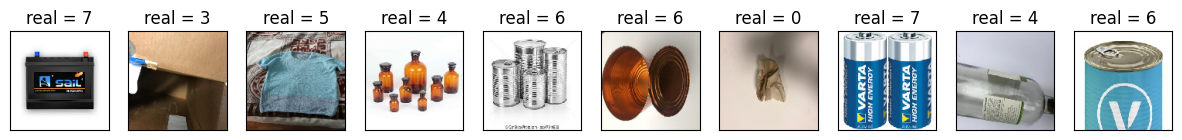

In [ ]:
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")
# Validate the Success of Image Loading
import HappyML.model_drawer as md

# Print the first 10 images of Training Set
for data, label in train_set:
    md.show_first_n_images(x_ary=data, y_real=np.argmax(label, axis=1), first_n=10, font_size=12)
    break

# Print the first 10 images of Testing Set
for data, label in test_set:
    md.show_first_n_images(x_ary=data, y_real=np.argmax(label, axis=1), first_n=10, font_size=12)
    break

In [ ]:
print("訓練集類別索引：", train_set.class_indices)
print("驗證集類別索引：", val_set.class_indices)
print("測試集類別索引：", test_set.class_indices)


訓練集類別索引： {'一般 general': 0, '塑膠 plastic': 1, '廚餘 food_waste': 2, '廢紙 waste_paper': 3, '玻璃 glass': 4, '衣服類 clothes (Textiles)': 5, '鐵鋁金屬 iron alumium': 6, '電池類 battery': 7}
驗證集類別索引： {'一般 general': 0, '塑膠 plastic': 1, '廚餘 food_waste': 2, '廢紙 waste_paper': 3, '玻璃 glass': 4, '衣服類 clothes (Textiles)': 5, '鐵鋁金屬 iron alumium': 6, '電池類 battery': 7}
測試集類別索引： {'一般 general': 0, '塑膠 plastic': 1, '廚餘 food_waste': 2, '廢紙 waste_paper': 3, '玻璃 glass': 4, '衣服類 clothes (Textiles)': 5, '鐵鋁金屬 iron alumium': 6, '電池類 battery': 7}


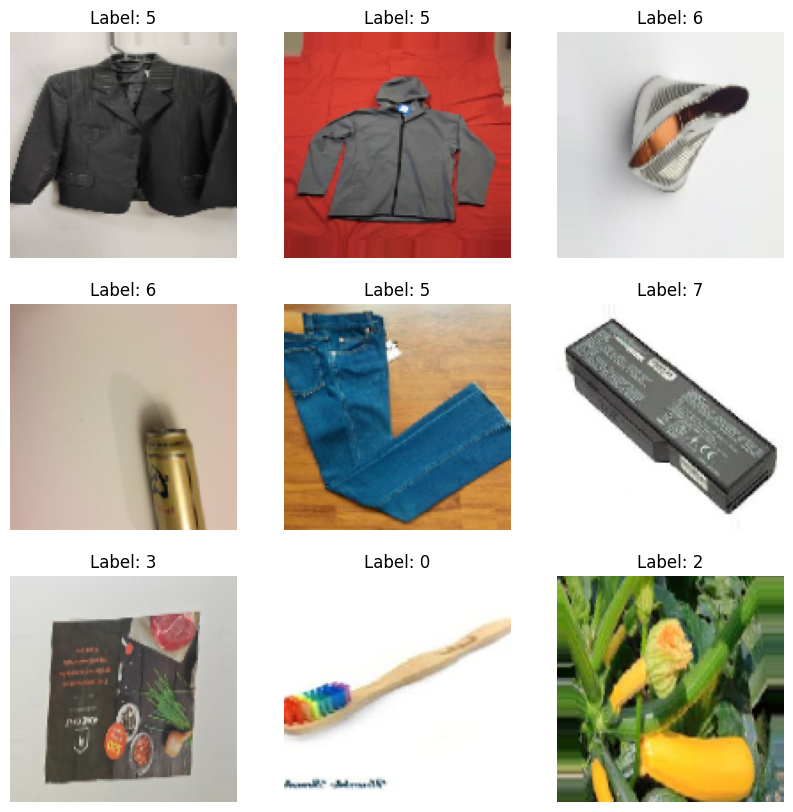

In [ ]:
# 從訓練集隨機取一批圖片
images, labels = next(train_set)

# 顯示圖片
plt.figure(figsize=(10, 10))
for i in range(9):  # 顯示前9張圖片
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")
plt.show()


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Create TensorBoard log directory
import os
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Start the TensorBoard
# %tensorboard --logdir logs --host=0.0.0.0 --port=6666 --path_prefix "/tensorboard"
%tensorboard --logdir logs --host=0.0.0.0 --port 6006

# --- For TensorBoard 403 Error ---
# Start the TensorBoard (Ignore the errors)
# %tensorboard --logdir logs --host=127.0.0.1 --port=6006 --load_fast=false

# Workaround for loading TensorBoard
# from google.colab import output
# output.serve_kernel_port_as_window(6006, path="")

Reusing TensorBoard on port 6006 (pid 88180), started 0:00:08 ago. (Use '!kill 88180' to kill it.)

In [ ]:
from IPython.display import IFrame
IFrame(src='/tensorboard', width='100%', height='800px')

In [ ]:
image_size = 128

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Resizing(image_size, image_size))

inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in inceptionV3.layers:
    layer.trainable = False
# Fine-tune the top layers of InceptionV3
for layer in inceptionV3.layers[-15:]:  # Unfreeze the last 10 layers
    layer.trainable = True

model.add(inceptionV3)

# Add a Global Average Pooling layer
model.add(GlobalAveragePooling2D())

# Output layer
model.add(layers.Dense(units=8, activation="softmax"))

# Compile
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

2024-12-12 20:28:25.363963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-12 20:28:25.364407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 [==============================] - 9s 0us/step


In [ ]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:
model.build(input_shape=(None, *train_set.image_shape))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (128, 128, 3)             0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               multiple                  16392     
                                                                 
Total params: 21819176 (83.23 MB)
Trainable params: 411272 (1.57 MB)
Non-trainable params: 21407904 (81.66 MB)
_________________________________________________________________


In [ ]:
nowdatetime = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", nowdatetime)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Training Model
epochs_metrics = model.fit(train_set, validation_data=val_set, batch_size=32, epochs=40, callbacks=[tensorboard_callback])

Epoch 1/40


2024-12-12 20:33:29.229491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1284/1285 [============================>.] - ETA: 0s - loss: 1.7115 - accuracy: 0.4470

2024-12-12 20:34:22.390572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1285/1285 [==============================] - 105s 76ms/step - loss: 1.7110 - accuracy: 0.4472 - val_loss: 1.1893 - val_accuracy: 0.6168
Epoch 2/40
1285/1285 [==============================] - 109s 85ms/step - loss: 1.0871 - accuracy: 0.6481 - val_loss: 0.8634 - val_accuracy: 0.7198
Epoch 3/40
1285/1285 [==============================] - 122s 95ms/step - loss: 0.8713 - accuracy: 0.7121 - val_loss: 0.7201 - val_accuracy: 0.7626
Epoch 4/40
1285/1285 [==============================] - 127s 99ms/step - loss: 0.7500 - accuracy: 0.7525 - val_loss: 0.6321 - val_accuracy: 0.7901
Epoch 5/40
1285/1285 [==============================] - 123s 96ms/step - loss: 0.6768 - accuracy: 0.7798 - val_loss: 0.5602 - val_accuracy: 0.8173
Epoch 6/40
1285/1285 [==============================] - 126s 98ms/step - loss: 0.6145 - accuracy: 0.7974 - val_loss: 0.5186 - val_accuracy: 0.8318
Epoch 7/40
1285/1285 [==============================] - 124s 96ms/step - loss: 0.5794 - accuracy: 0.8061 - val_loss: 0.4803 - val

In [ ]:
model.save(f'trained-{nowdatetime}.keras')

In [ ]:
images, labels = next(test_set)

In [ ]:
pred = model.predict(images)

1/1 [==============================] - 0s 150ms/step


In [ ]:
Y_pred = np.argmax(pred, axis=1)
Y_pred

array([6, 5, 1, 3, 5, 6, 6, 2, 1, 5])

In [ ]:
Y_labels = np.argmax(labels, axis=1)
Y_labels

array([4, 5, 1, 3, 5, 6, 6, 2, 1, 5])

1/1 [==============================] - 0s 100ms/step


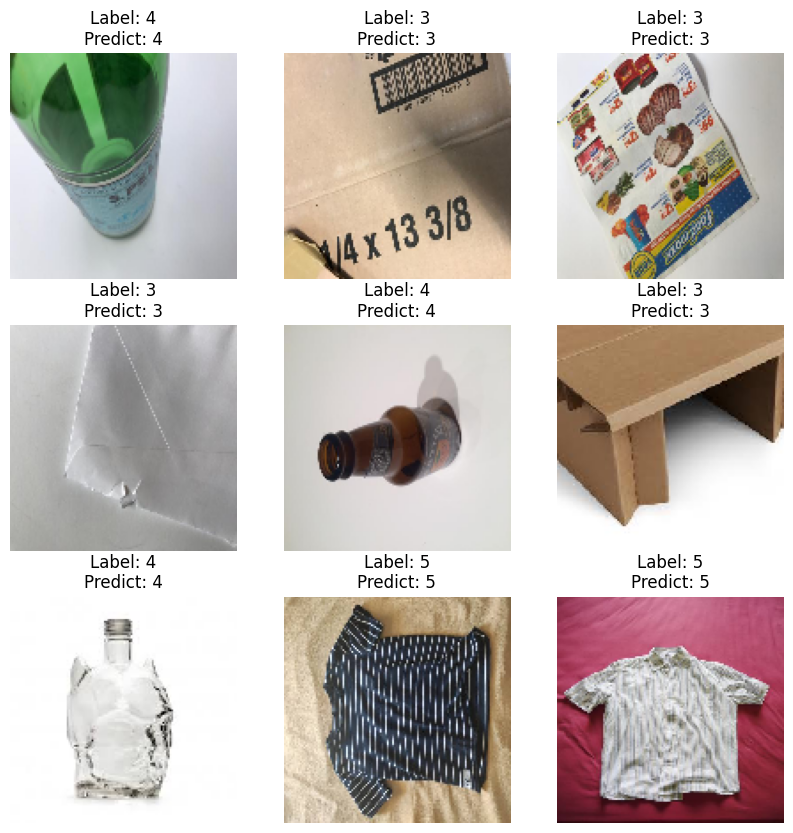

In [ ]:
# 從訓練集隨機取一批圖片
images, labels = next(test_set)
pred = model.predict(images)
Y_pred = np.argmax(pred, axis=1)
Y_labels = np.argmax(labels, axis=1)

# 顯示圖片
plt.figure(figsize=(10, 10))
for i in range(9):  # 顯示前9張圖片
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {Y_labels[i]}\nPredict: {Y_pred[i]}")
    plt.axis("off")
plt.show()

In [ ]:
# Model Evaluation
test_loss, test_acc = model.evaluate(test_set)
print("Loss of Test:", test_loss)
print("Accuracy of Test:", test_acc)

322/322 [==============================] - 13s 40ms/step - loss: 0.2828 - accuracy: 0.9160
Loss of Test: 0.28278443217277527
Accuracy of Test: 0.9160186648368835
